In [20]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
import pandas as pd

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 20}) #make plots more readable

### Yumi's RA/DEC ---> Magellanic Stream Coorindates
import MagellanicStream as ms

### Functions used in this code
import density_functions as dfunc

### Stuff Writtten by A Really Cool Professor
import dlnpyutils as dlpu

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [2]:
###################
### Import Data ###
###################

#parsec
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Structure/logisochrones.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

#DR16 r13
r13 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Structure/lmc_rgbmembers.r13-l33-58672.fits.gz',1)
clnr = np.where((r13['FE_H']>-9999.0)&(r13['AK_TARG']>-9999.0)&(r13['LOGG']>0.0)&\
                (r13['M_H_ERR']>-90.0)&(r13['C_FE']>-9999.0)&(r13['N_FE']>-9999.0))

r13 = r13[clnr]

#Transform APOGEE RA and DEC to Magellanic Stream L and B
c_icrs = SkyCoord(ra=r13['RA']*u.degree, dec=r13['DEC']*u.degree)
c_ms = c_icrs.transform_to(ms.MagellanicStream)
ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

for i in range(len(ms_lg)):
    if ms_lg[i] - 360 < -180:
        ms_lg[i] += 360.0

In [3]:
##############
### Fields ###
##############

field_str = ['30Dor','LMC1','LMC2','LMC3','LMC4','LMC5','LMC6','LMC7','LMC8','LMC9','LMC10','LMC11','LMC12',
             'LMC13','LMC14','LMC15','LMC16','LMC17']

In [4]:
### blue loop cut
bloop = np.where((r13['TEFF']>=4100)&(r13['H']<=13.0)&((r13['J']-r13['K'])<=0.95))

bloop_cut = []
for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    if i not in np.squeeze(r13).tolist():
        bloop_cut.append(i)
        
bloopr13 = r13[bloop_cut]

fields = []
for i in range(len(field_str)):
    fields.append(np.where(bloopr13['FIELD']==field_str[i]))

In [5]:
######################
### Calculate Ages ###
######################

abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(r13)):
    x_C.append(sol_xm[0]*10**(r13['C_FE']+r13['FE_H']-r13['M_H']))
    x_N.append(sol_xm[1]*10**(r13['N_FE']+r13['FE_H']-r13['M_H']))
    x_O.append(sol_xm[2]*10**(r13['O_FE']+r13['FE_H']-r13['M_H']))
    x_Mg.append(sol_xm[3]*10**(r13['Mg_FE']+r13['FE_H']-r13['M_H']))
    x_Ca.append(sol_xm[4]*10**(r13['Ca_FE']+r13['FE_H']-r13['M_H']))
    x_S.append(sol_xm[5]*10**(r13['S_FE']+r13['FE_H']-r13['M_H']))
    x_Si.append(sol_xm[6]*10**(r13['SI_FE']+r13['FE_H']-r13['M_H']))
    x_Fe.append(sol_xm[7]*10**(r13['FE_H']-r13['M_H']))
    
facts = []
factsalp = []
factsCNO = []
factsCN = []
factsCO = []
for j in range(len(r13)):
    numerCN = x_C[j]+x_N[j]
    denomCN = sum(sol_xm[0:2])
    
    numerCO = x_C[j]+x_O[j]
    denomCO = sol_xm[0]+sol_xm[2]
factsCN.append(numerCN/denomCN)
factsCO.append(numerCO/denomCO)

metscorr = np.log10(0.638*(np.asarray(factsCN)+0.362))

xLMC, yLMC, stardist = dfunc.LMCdisk_cart(r13['RA'],r13['DEC'])
corabsK = dfunc.absmag(r13['K'],stardist)-r13['AK_TARG']
parage = dfunc.find_age(np.log10(r13['TEFF']),corabsK,dfunc.sal(r13['M_H'],metscorr),r13['LOGG'])
parage = np.squeeze(parage)

#bloop cut ages
bloopage = parage[bloop_cut]
bloopabsH = (dfunc.absmag(r13['H'],stardist)-r13['AK_TARG'])[bloop_cut]

In [50]:
##############
###  Bins  ###
##############

young = np.where(bloopage<=np.log10(0.5*10**9))
yless = np.where((bloopage>np.log10(0.5*10**9))&(bloopage<=np.log10(2.0*10**9)))
ymed = np.where((bloopage>np.log10(2.0*10**9))&(bloopage<=np.log10(7*10**9)))
omed = np.where((bloopage>np.log10(7*10**9))&(bloopage<=np.log10(10.5*10**9)))
old = np.where(bloopage>np.log10(10.5*10**9))

age_bins = [young,yless,ymed,omed,old]

radius = np.sqrt(np.square(xLMC)+np.square(yLMC))[bloop_cut]

zero = np.where(radius<1.0)
one = np.where((radius>=1.0)&(radius<2.0))
two = np.where((radius>=2.0)&(radius<3.0))
three = np.where((radius>=3.0)&(radius<4.0))
four = np.where((radius>=4.0)&(radius<5.0))
five = np.where((radius>=5.0)&(radius<6.0))
six = np.where(radius>=6.0)

rad_bins = [zero,one,two,three,four,five,six]

### yoradius
yozero = np.where((bloopage<=np.log10(0.5*10**9))&(radius<1.0))
yoone = np.where((bloopage<=np.log10(0.5*10**9))&(radius>=1.0)&(radius<2.0))
yotwo = np.where((bloopage<=np.log10(0.5*10**9))&(radius>=2.0)&(radius<3.0))
yothree = np.where((bloopage<=np.log10(0.5*10**9))&(radius>=3.0)&(radius<4.0))
yofour = np.where((bloopage<=np.log10(0.5*10**9))&(radius>=4.0)&(radius<5.0))
yofive = np.where((bloopage<=np.log10(0.5*10**9))&(radius>=5.0)&(radius<6.0))
yosix = np.where((bloopage<=np.log10(0.5*10**9))&(radius>=6.0))

yoradius = [yozero,yoone,yotwo,yothree,yofour,yofive,yosix]

### ylradius
ylzero = np.where((bloopage>np.log10(0.5*10**9))&(bloopage<=np.log10(2.0*10**9))&(radius<1.0))
ylone = np.where((bloopage>np.log10(0.5*10**9))&(bloopage<=np.log10(2.0*10**9))&(radius>=1.0)&(radius<2.0))
yltwo = np.where((bloopage>np.log10(0.5*10**9))&(bloopage<=np.log10(2.0*10**9))&(radius>=2.0)&(radius<3.0))
ylthree = np.where((bloopage>np.log10(0.5*10**9))&(bloopage<=np.log10(2.0*10**9))&(radius>=3.0)&(radius<4.0))
ylfour = np.where((bloopage>np.log10(0.5*10**9))&(bloopage<=np.log10(2.0*10**9))&(radius>=4.0)&(radius<5.0))
ylfive = np.where((bloopage>np.log10(0.5*10**9))&(bloopage<=np.log10(2.0*10**9))&(radius>=5.0)&(radius<6.0))
ylsix = np.where((bloopage>np.log10(0.5*10**9))&(bloopage<=np.log10(2.0*10**9))&(radius>=6.0))

ylradius = [ylzero,ylone,yltwo,ylthree,ylfour,ylfive,ylsix]

### ymradius
ymzero = np.where((bloopage>np.log10(2.0*10**9))&(bloopage<=np.log10(7*10**9))&(radius<1.0))
ymone = np.where((bloopage>np.log10(2.0*10**9))&(bloopage<=np.log10(7*10**9))&(radius>=1.0)&(radius<2.0))
ymtwo = np.where((bloopage>np.log10(2.0*10**9))&(bloopage<=np.log10(7*10**9))&(radius>=2.0)&(radius<3.0))
ymthree = np.where((bloopage>np.log10(2.0*10**9))&(bloopage<=np.log10(7*10**9))&(radius>=3.0)&(radius<4.0))
ymfour = np.where((bloopage>np.log10(2.0*10**9))&(bloopage<=np.log10(7*10**9))&(radius>=4.0)&(radius<5.0))
ymfive = np.where((bloopage>np.log10(2.0*10**9))&(bloopage<=np.log10(7*10**9))&(radius>=5.0)&(radius<6.0))
ymsix = np.where((bloopage>np.log10(2.0*10**9))&(bloopage<=np.log10(7*10**9))&(radius>=6.0))

ymradius = [ymzero,ymone,ymtwo,ymthree,ymfour,ymfive,ymsix]

### omradius
omzero = np.where((bloopage>np.log10(7*10**9))&(bloopage<=np.log10(10.5*10**9))&(radius<1.0))
omone = np.where((bloopage>np.log10(7*10**9))&(bloopage<=np.log10(10.5*10**9))&(radius>=1.0)&(radius<2.0))
omtwo = np.where((bloopage>np.log10(7*10**9))&(bloopage<=np.log10(10.5*10**9))&(radius>=2.0)&(radius<3.0))
omthree = np.where((bloopage>np.log10(7*10**9))&(bloopage<=np.log10(10.5*10**9))&(radius>=3.0)&(radius<4.0))
omfour = np.where((bloopage>np.log10(7*10**9))&(bloopage<=np.log10(10.5*10**9))&(radius>=4.0)&(radius<5.0))
omfive = np.where((bloopage>np.log10(7*10**9))&(bloopage<=np.log10(10.5*10**9))&(radius>=5.0)&(radius<6.0))
omsix = np.where((bloopage>np.log10(7*10**9))&(bloopage<=np.log10(10.5*10**9))&(radius>=6.0))

omradius = [omzero,omone,omtwo,omthree,omfour,omfive,omsix]

### olradius
olzero = np.where((bloopage>np.log10(10.5*10**9))&(radius<1.0))
olone = np.where((bloopage>np.log10(10.5*10**9))&(radius>=1.0)&(radius<2.0))
oltwo = np.where((bloopage>np.log10(10.5*10**9))&(radius>=2.0)&(radius<3.0))
olthree = np.where((bloopage>np.log10(10.5*10**9))&(radius>=3.0)&(radius<4.0))
olfour = np.where((bloopage>np.log10(10.5*10**9))&(radius>=4.0)&(radius<5.0))
olfive = np.where((bloopage>np.log10(10.5*10**9))&(radius>=5.0)&(radius<6.0))
olsix = np.where((bloopage>np.log10(10.5*10**9))&(radius>=6.0))

olradius = [olzero,olone,oltwo,olthree,olfour,olfive,olsix]

In [51]:
rad_bins[0]

(array([  9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,
         22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,
         35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
         48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
         61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
         74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
         87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
        100, 101, 102, 103, 104, 105]),)

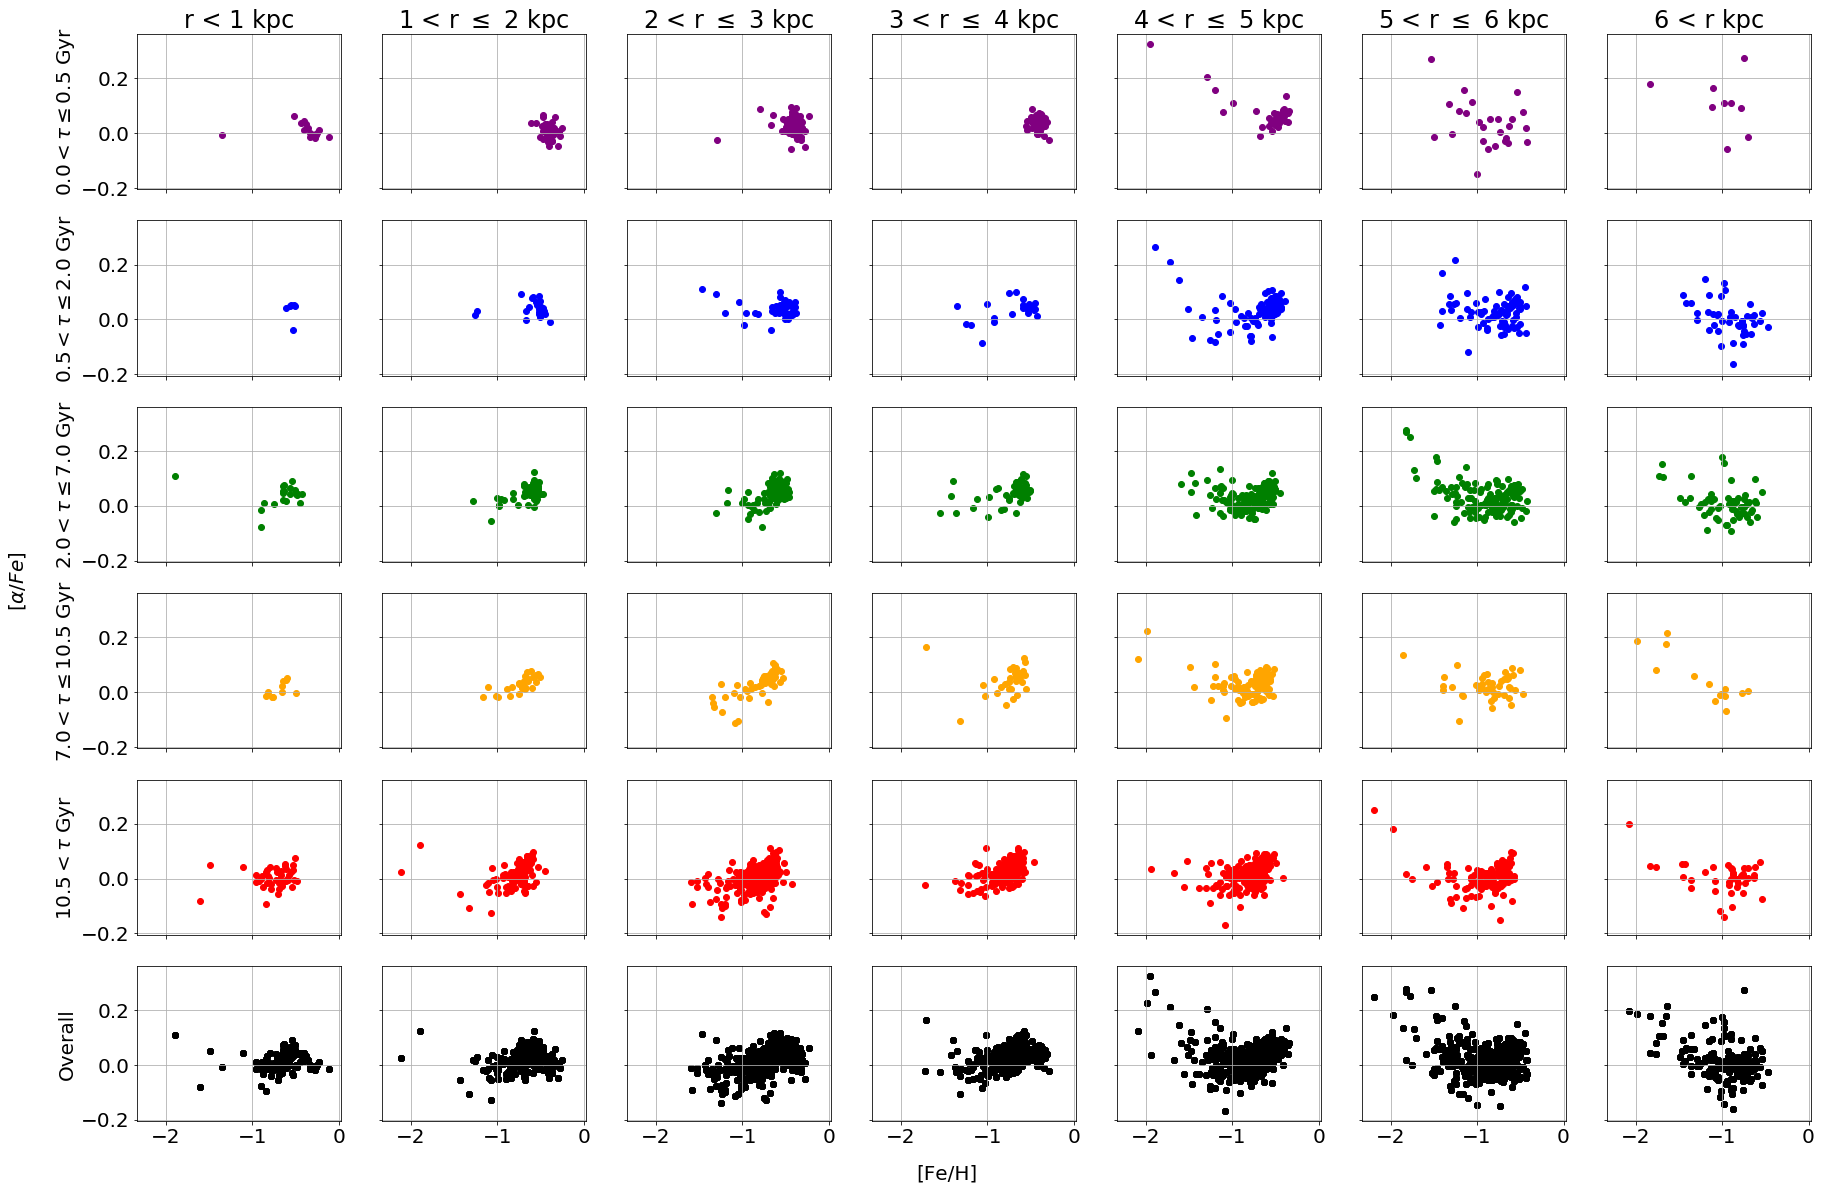

In [52]:
fig, ax = plt.subplots(len(range(6)),len(range(7)),sharex=True,sharey=True,figsize=[30,20])
for i in range(5):
    if i == 0:
        for j in range(7):
            ax[i,j].scatter(r13['FE_H'][yoradius[j]],(r13['ALPHA_M']+r13['M_H']-r13['FE_H'])[yoradius[j]],c='purple')
            ax[i,j].grid()
    if i == 1:
        for j in range(7):
            ax[i,j].scatter(r13['FE_H'][ylradius[j]],(r13['ALPHA_M']+r13['M_H']-r13['FE_H'])[ylradius[j]],c='blue')
            ax[i,j].grid()
    if i == 2:
        for j in range(7):
            ax[i,j].scatter(r13['FE_H'][ymradius[j]],(r13['ALPHA_M']+r13['M_H']-r13['FE_H'])[ymradius[j]],c='green')
            ax[i,j].grid()
    if i == 3:
        for j in range(7):
            ax[i,j].scatter(r13['FE_H'][omradius[j]],(r13['ALPHA_M']+r13['M_H']-r13['FE_H'])[omradius[j]],c='orange')
            ax[i,j].grid()
    if i == 4:
        for j in range(7):
            ax[i,j].scatter(r13['FE_H'][olradius[j]],(r13['ALPHA_M']+r13['M_H']-r13['FE_H'])[olradius[j]],c='red')
            ax[i,j].grid()
            
    for j in range(7):
        ax[5,j].scatter(r13['FE_H'][rad_bins[j]],(r13['ALPHA_M']+r13['M_H']-r13['FE_H'])[rad_bins[j]],c='k')
        ax[5,j].grid()

rad_labels = ['r < 1 kpc','1 < r $\leq$ 2 kpc','2 < r $\leq$ 3 kpc','3 < r $\leq$ 4 kpc','4 < r $\leq$ 5 kpc',
              '5 < r $\leq$ 6 kpc','6 < r kpc']
for k in range(7):
    ax[0,k].set_title(r'{}'.format(rad_labels[k]))
    #ax[4,k].set_xlabel(r'[Fe/H]')
    
age_labels = ['$0.0 < \\tau \leq 0.5$ Gyr','$0.5 < \\tau \leq 2.0$ Gyr','$2.0 < \\tau \leq 7.0$ Gyr',
              '$7.0 < \\tau \leq 10.5$ Gyr','$10.5 < \\tau$ Gyr','Overall']
for l in range(6):
    ax[l,0].set_ylabel(r'{}'.format(age_labels[l]))
    

fig.text(0.5, 0.085, '[Fe/H]', ha='center')
fig.text(0.065, 0.5, '$[\\alpha/Fe]$', va='center', rotation='vertical')

plt.show()

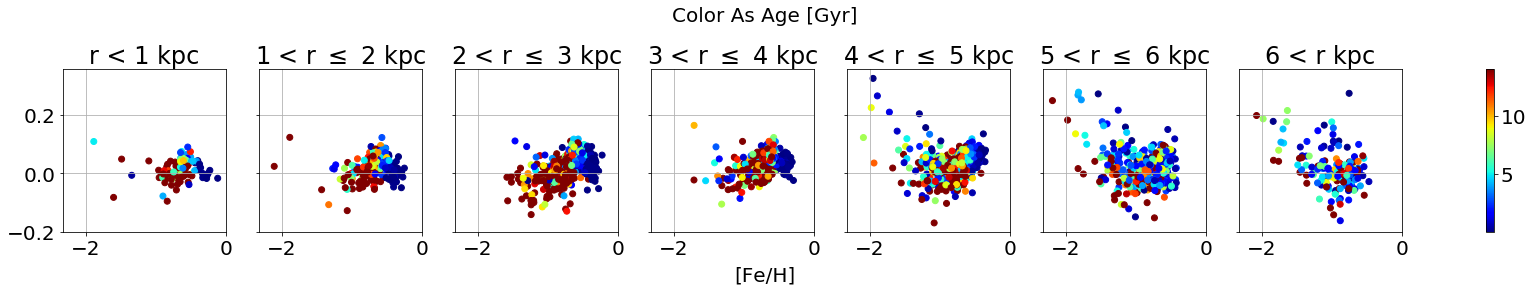

In [86]:
rad_labels = ['r < 1 kpc','1 < r $\leq$ 2 kpc','2 < r $\leq$ 3 kpc','3 < r $\leq$ 4 kpc','4 < r $\leq$ 5 kpc',
              '5 < r $\leq$ 6 kpc','6 < r kpc']

fig, ax = plt.subplots(1,7,sharex=True,sharey=True,figsize=[30,3])

for i in range(7):
    im = ax[i].scatter(r13['FE_H'][rad_bins[i]],(r13['ALPHA_M']+r13['M_H']-r13['FE_H'])[rad_bins[i]],
                  c=10**bloopage[rad_bins[i]]/10**9,cmap='jet',vmin=10**min(bloopage)/10**9,vmax=14)
    ax[i].set_title(r'{}'.format(rad_labels[i]))
    ax[i].grid()
fig.colorbar(im, ax=ax.ravel().tolist())
fig.text(0.45,1.1,r'Color As Age [Gyr]',ha='center')
fig.text(0.45, -0.1, '[Fe/H]', ha='center')
# fig.ylabel(r'[$\alpha$/Fe]')
plt.show()

In [58]:
10**min(bloopage)/10**9

0.015214410235773329